# Installs

In [91]:
!pip install inflection

# Imports

## Libraries

In [171]:
import pandas as pd
import inflection
import math
import locale
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datetime import timedelta
%matplotlib inline
import numpy as np

## Data

In [2]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_stores_raw = pd.read_csv('datasets/store.csv', low_memory=False)

In [3]:
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store')
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
689369,1085,2,2013-10-22,8392,799,1,1,0,0,c,a,4030.0,2.0,2015.0,0,NaN,NaN,NaN


# Data Description

## Rename Columns

In [4]:
df1 = df_raw.copy()
old_cols = df1.columns
new_cols = list(map(inflection.underscore, old_cols))
df1.columns = new_cols
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data Dimensions

In [5]:
df1.shape

(1017209, 18)

## Data Types

In [6]:
df1['date'] = pd.to_datetime(df1['date'], )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NAs

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NAs

In [8]:
# competition_distance               2642
max_value = 10 * df1['competition_distance'].max()
df1.loc[df1['competition_distance'].isna(), 'competition_distance'] = max_value

# competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply(lambda row: row['date'].month if math.isnan(row['competition_open_since_month']) else row['competition_open_since_month'], axis=1)

# competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply(lambda row: row['date'].year if math.isnan(row['competition_open_since_year']) else row['competition_open_since_year'], axis=1)

# promo2_since_week               508031
df1['promo2_since_week'] = df1.apply(lambda row: row['date'].week if math.isnan(row['promo2_since_week']) else row['promo2_since_week'], axis=1)

# promo2_since_year               508031
df1['promo2_since_year'] = df1.apply(lambda row: row['date'].year if math.isnan(row['promo2_since_year']) else row['promo2_since_year'], axis=1)

# promo_interval                  508031
df1.loc[df1['promo_interval'].isna(), 'promo_interval'] = ''

In [9]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## Check Types

In [10]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object


## Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributes

In [14]:
num_metrics = num_attributes.describe().T
num_metrics = num_metrics.rename(columns={'25%': 'q1', '50%': 'median', '75%': 'q3'})
num_metrics['amplitude'] = num_metrics['max'] - num_metrics['min']
num_metrics['ifq'] = num_metrics['q3'] - num_metrics['q1']
num_metrics['skew'] = num_attributes.apply(lambda x: x.skew())
num_metrics['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())
num_metrics = num_metrics[['mean', 'median', 'min', 'q1', 'q3', 'max', 'std', 'ifq', 'amplitude', 'skew', 'kurtosis']]
num_metrics

,mean,median,min,q1,q3,max,std,ifq,amplitude,skew,kurtosis
store,558.429727,558.0,1.0,280.0,838.0,1115.0,321.908651,558.0,1114.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.0,2.0,6.0,7.0,1.997391,4.0,6.0,0.001593,-1.246873
sales,5773.818972,5744.0,0.0,3727.0,7856.0,41551.0,3849.926175,4129.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,0.0,405.0,837.0,7388.0,464.411734,432.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.0,1.0,1.0,1.0,0.375539,0.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.0,0.0,1.0,1.0,0.485759,1.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.0,0.0,0.0,1.0,0.383056,0.0,1.0,1.677842,0.815154
competition_distance,7386.296140,2330.0,20.0,710.0,6910.0,758600.0,39101.217148,6200.0,758580.0,18.434533,350.869718
competition_open_since_month,6.786849,7.0,1.0,4.0,10.0,12.0,3.311087,6.0,11.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,1900.0,2008.0,2014.0,2015.0,5.515593,6.0,115.0,-7.235657,124.071304


/home/biazotogabriel/.anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='customers', ylabel='Density'>

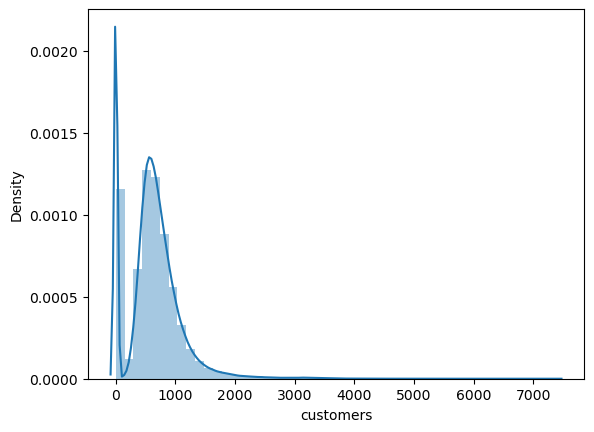

In [47]:
sns.distplot(df1['customers'])

### Categorical Attributes


In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

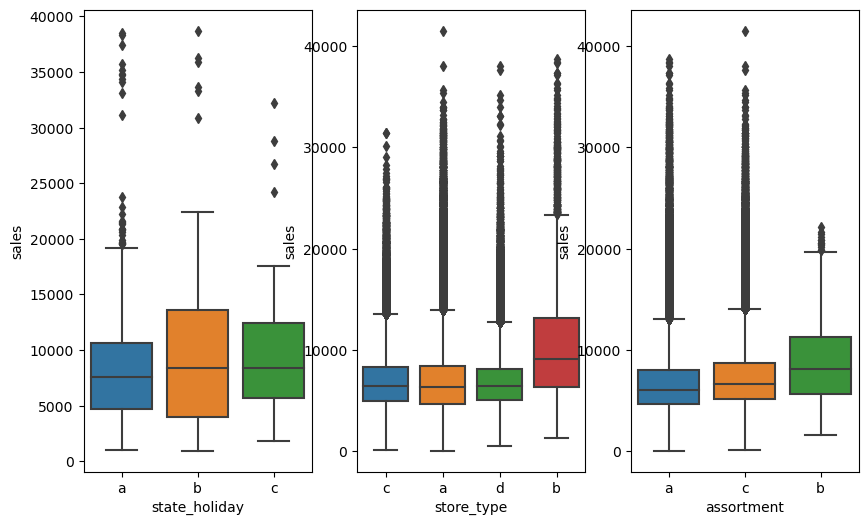

In [52]:
plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
sns.boxplot(x='state_holiday', y='sales', data=aux1)
plt.subplot(1,3,2)
aux1 = df1[(df1['sales'] > 0)]
sns.boxplot(x='store_type', y='sales', data=aux1)
plt.subplot(1,3,3)
aux1 = df1[(df1['sales'] > 0)]
sns.boxplot(x='assortment', y='sales', data=aux1)
plt.show()
plt.close()


# Hipotesis

## Mindmap

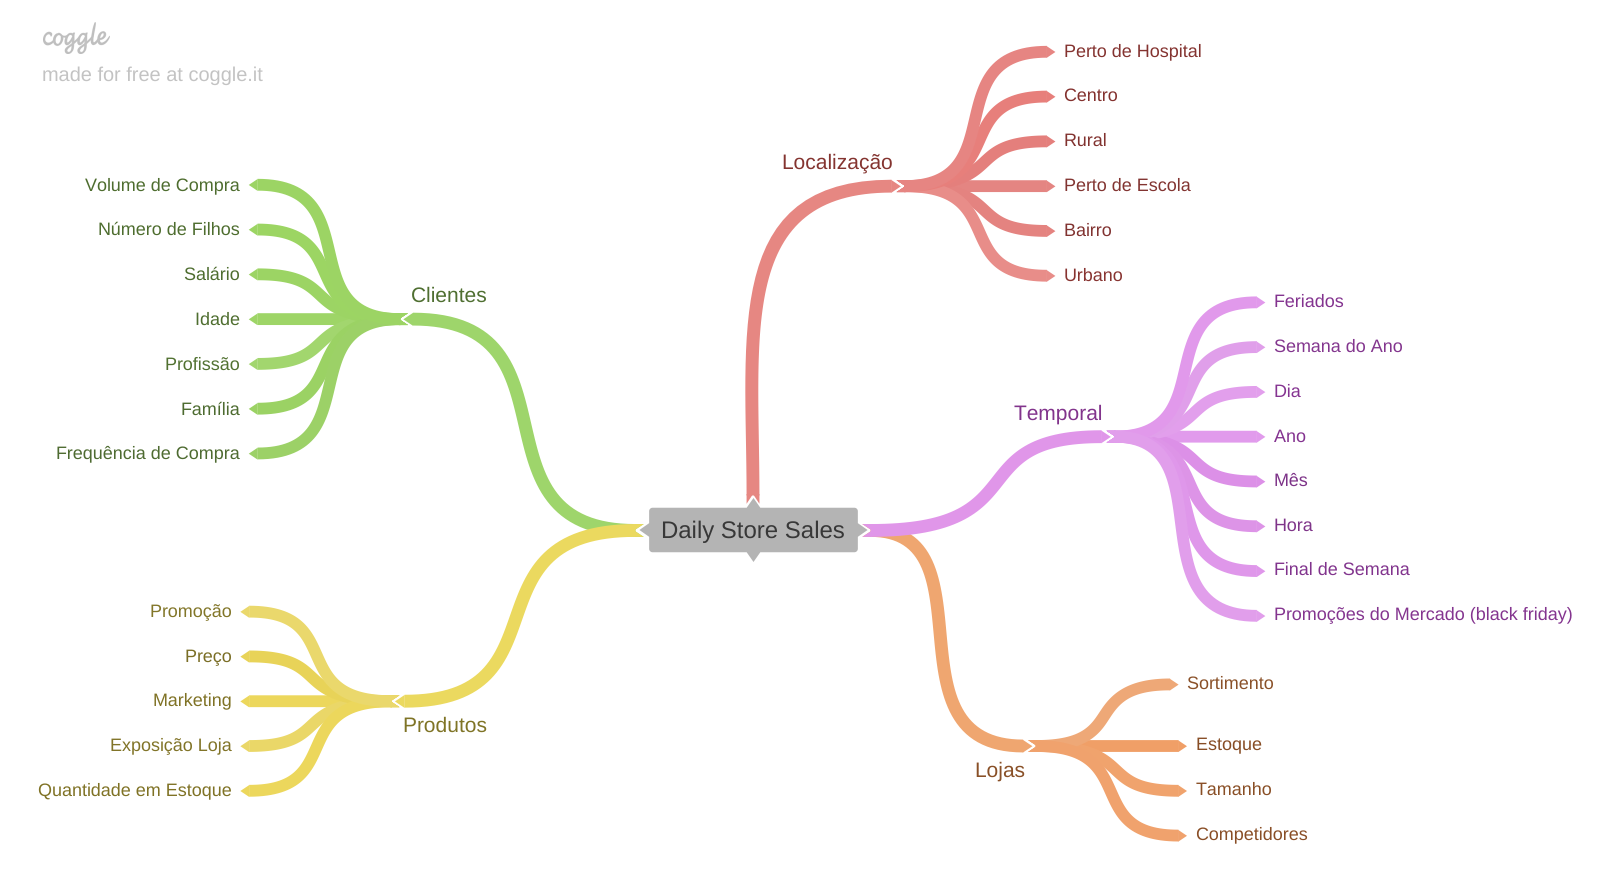

In [18]:
Image.open('./images/mind_map_hipotesis.png')

## Creating Hipotesis

### Store Hipotesis

- Lojas com maior quadro de funcionarios deveriam vender mais  
- Lojas com maior estoque deveriam vender mais  
- Lojas com maior porte deveriam vender mais  
- Lojas com menor porte deveriam vender menos  
- Lojas com maior sortimento deveriam vender mais  

### Product Hipotesis

- Lojas que investem mais em marketing deveriam vender mais  
- Lojas que expoem mais os produtos nas vitrines deveriam vender mais  
- Lojas com menores preços deveriam vender mais  
- Lojas que tem menores preços por mais tempo deveriam vender mais  
- Lojas com maior quantidade de produtos em estoque deveriam vender mais  
- Lojas com campanhas de promoção deveriam vender mais  

### Time Hipotesis

- Lojas que tem mais feriados deveriam vender menos  
- Lojas que abrem nos primeiros seis meses deveriam vender mais  
- Lojas que abrem nos finais de semana deveriam vender mais  

## Selecting Hipotesis

1 - Lojas com sortimentos deveriam vender mais  
2 - Lojas com competidores mais próximos deveriam vender menos  
3 - Lojas com competidores a mais tempo deveriam vender mais  
4 - Lojas com promoções ativas por mais tempo deveriam vender mais  
5 - Lojas com mais dias de promoção deveriam vender mais  
6 - Lojas com mais promoções consecutivas deveriam vender mais  
7 - Lojas abertas durante o feriado de natal deveriam vender mais  
8 - Lojas deveriam vender mais ao longo dos anos  
9 - Lojas deveriam vender mais no segundo semestre do ano  
10 - Lojas deveriam vender mais depois do dia 10 de cada mês  
11 - Lojas deveriam vender menos aos finais de semana  
12 - Lojas deveriam vender menos durante os feriados escolares  

# Feature Engineering

In [19]:
# definir se a loja estava em promoção no dia da venda
locale.setlocale(locale.LC_TIME, ('en_US', 'UTF-8'))
df1['in_promo'] = df1[['date', 'promo_interval']].apply(lambda x: 1 if x['date'].strftime('%b') in x['promo_interval'].split(',') else 0, axis=1)

In [118]:
df2 = df1.copy()

In [126]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = pd.to_datetime({'year': df2['competition_open_since_year'],
                                           'month': df2['competition_open_since_month'],
                                           'day': 1})
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = pd.to_datetime(df2['promo2_since_year'] * 1000 + df2['promo2_since_week'] * 10, format='%Y%W%w')
df2['promo_since'] = df2['promo_since'] - timedelta(days=7)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#from functools import partial 
# assortment
df2['assortment'] = df2['assortment'].map(lambda x: {'a': 'basic',
                                                     'b': 'extra',
                                                     'c': 'extended'}.get(x, x))

# state holiday
df2['state_holiday'] = df2['state_holiday'].map(lambda x: {'a': 'public',
                                                           'b': 'easter',
                                                           'c': 'christmas',
                                                           '0': 'regular'}.get(x, x))

In [127]:
df2.sample(5).T

,971788,999436,434097,688064,143068
store,294,67,33,895,349
day_of_week,7,3,6,3,3
date,2013-02-10 00:00:00,2013-01-16 00:00:00,2014-06-07 00:00:00,2013-10-23 00:00:00,2015-03-25 00:00:00
sales,0,5102,8487,9288,7460
customers,0,619,891,877,768
open,0,1,1,1,1
promo,0,0,0,1,0
state_holiday,regular,regular,regular,regular,regular
school_holiday,0,0,0,0,0
store_type,a,a,a,a,c


# Variables Filtering/Selection

In [128]:
df3 = df2.copy()

## Lines

In [129]:
#Filtrando linhas
# 'open' != 0
# 'sales' > 0
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Columns

In [130]:
#Filtrando colunas
# 'customers'
cols_drop = ['customers', 'open', 'promo_interval']
df3 = df3.drop(cols_drop, axis=1)

In [131]:

df3

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,in_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-08-02,-1
1,2,5,2015-07-31,6064,1,regular,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-28,278
2,3,5,2015-07-31,8314,1,regular,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-04-03,225
3,4,5,2015-07-31,13995,1,regular,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-08-02,-1
4,5,5,2015-07-31,4822,1,regular,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-08-02,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public,1,b,basic,150.0,...,0,2013,1,1,1,2013-00,2006-09-01,77,2013-01-06,-1
1016827,733,2,2013-01-01,10765,0,public,1,b,extra,860.0,...,0,2013,1,1,1,2013-00,1999-10-01,161,2013-01-06,-1
1016863,769,2,2013-01-01,5035,0,public,1,b,extra,840.0,...,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-25,5
1017042,948,2,2013-01-01,4491,0,public,1,b,extra,1430.0,...,0,2013,1,1,1,2013-00,2013-01-01,0,2013-01-06,-1


# Exploratory Data Analisis

In [132]:
df4 = df3.copy()

## Univariate Analysis

### Response Variables

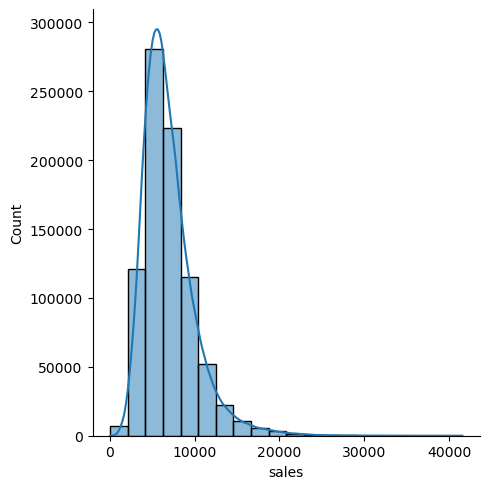

In [133]:
sns.displot(df4['sales'], bins=20, kde=True)
#sns.barplot(x=["A", "B", "C"], y=[1, 3, 2])


### Numerical Variables

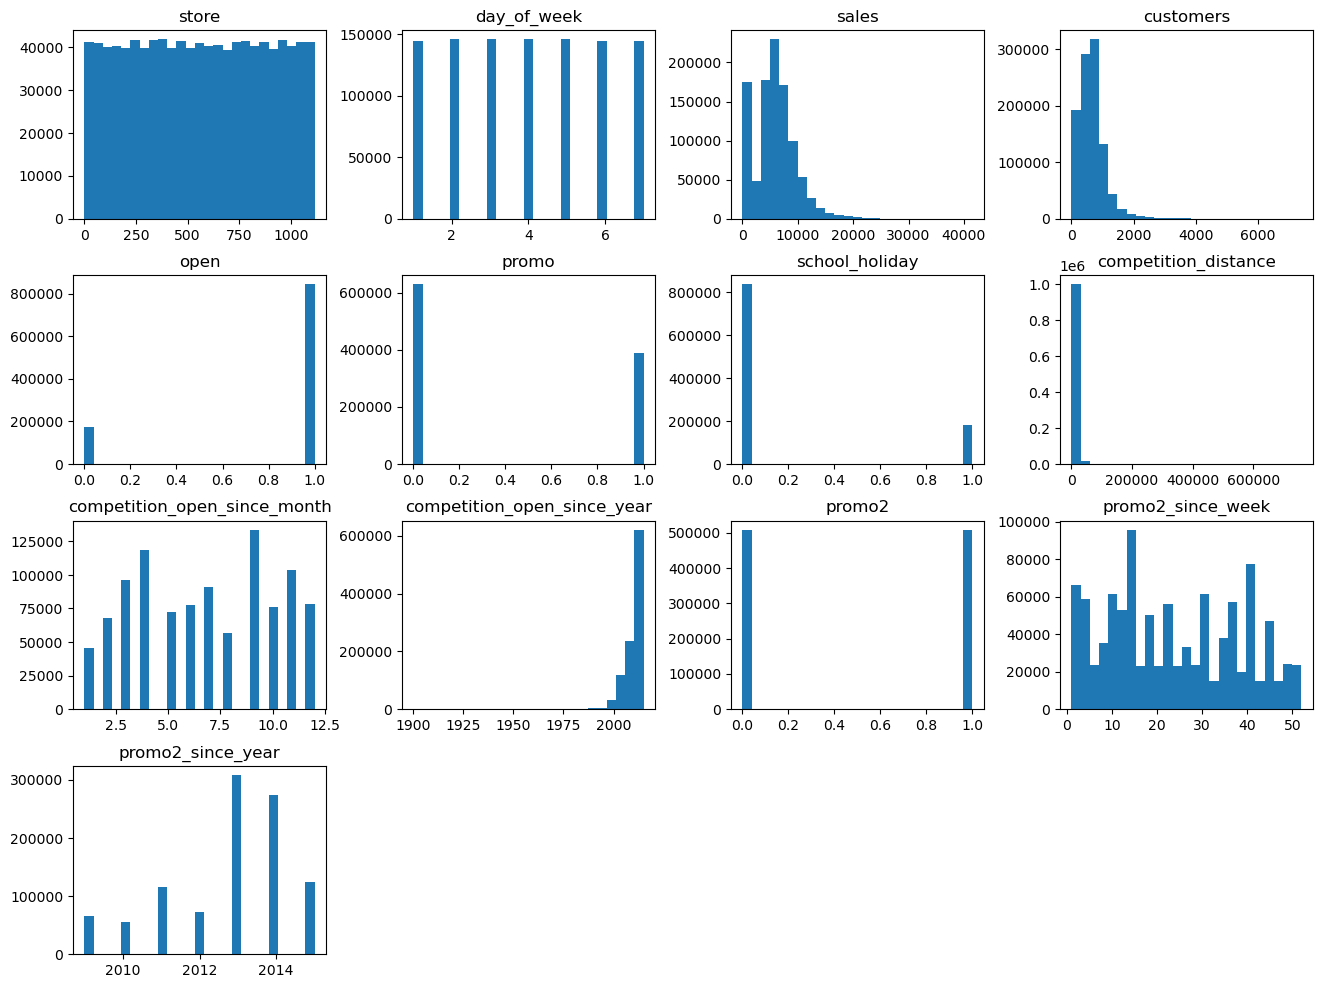

In [134]:
num_attributes.hist(bins=25, grid=False, figsize=(16,12));

### Categorical Variables

In [135]:
df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

/home/biazotogabriel/.anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


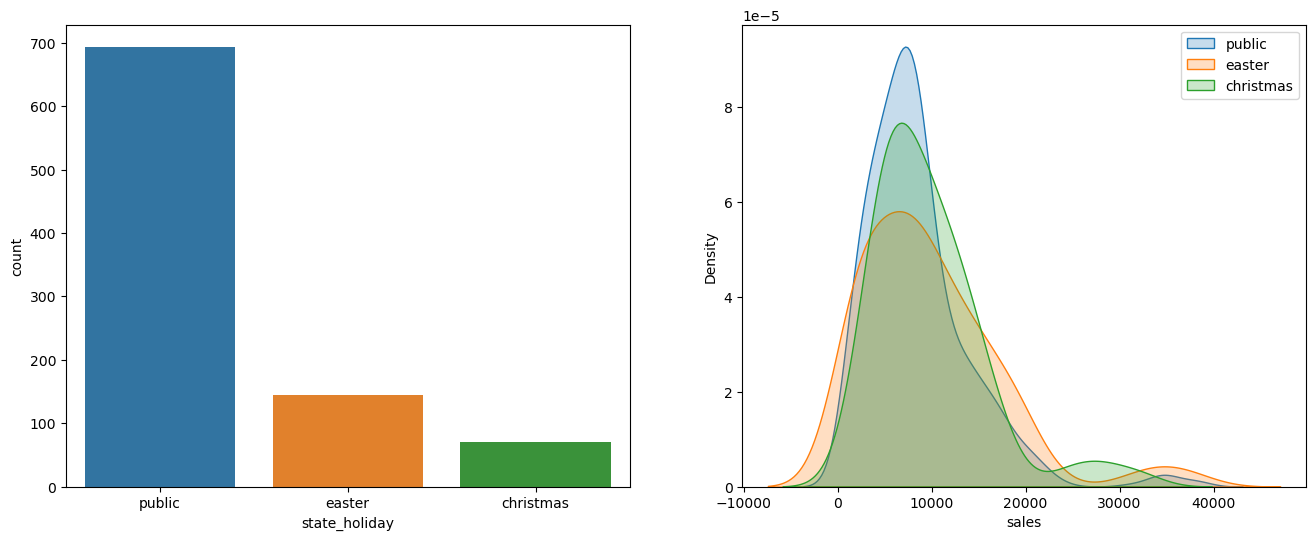

In [137]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
df_aux = df4[df4['state_holiday'] != 'regular']
sns.countplot(df_aux['state_holiday'])
plt.subplot(1, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public']['sales'], label='public', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter']['sales'], label='easter', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()

/home/biazotogabriel/.anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


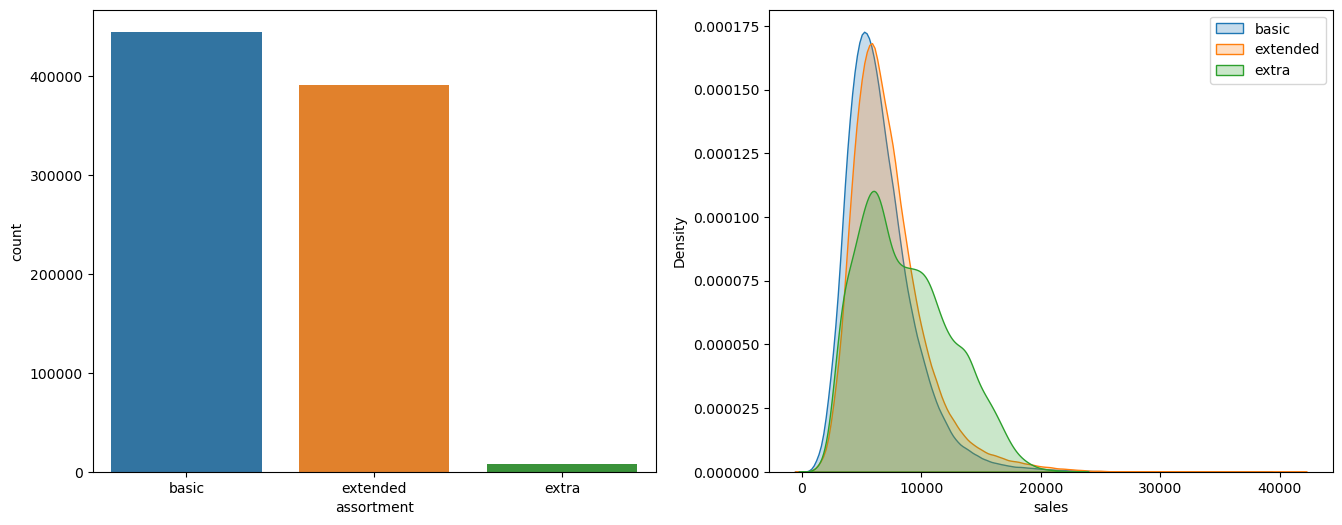

In [138]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
sns.countplot(df4['assortment'])
plt.subplot(1, 2, 2)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()

/home/biazotogabriel/.anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


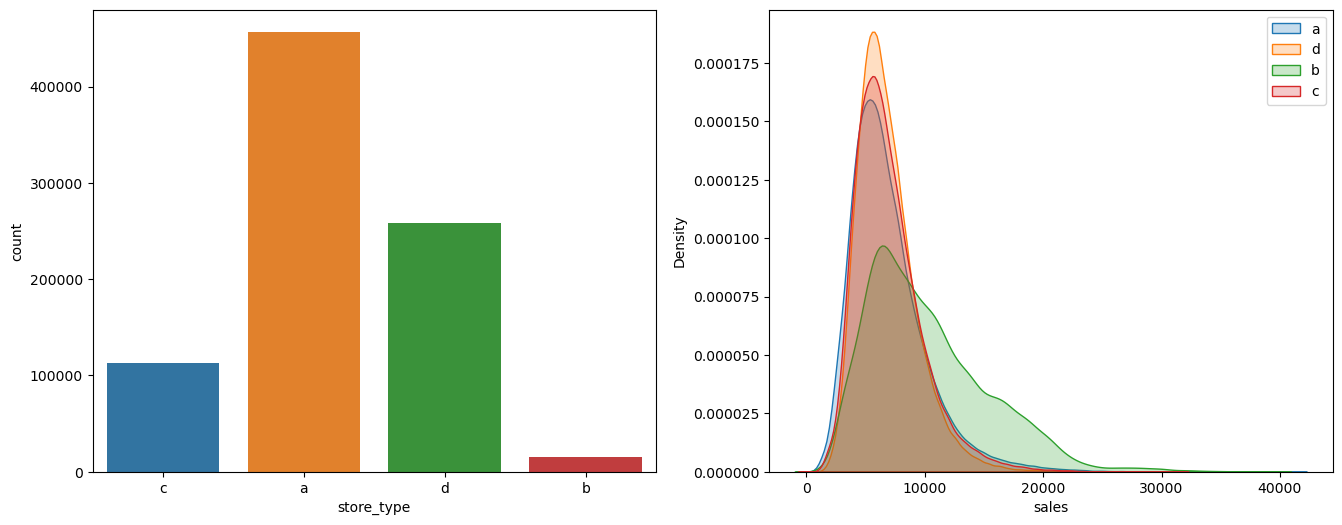

In [139]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
sns.countplot(df4['store_type'])
plt.subplot(1, 2, 2)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
plt.legend()

## Bivariate Analysis

### H1 - Lojas com maiores sortimentos deveriam vender mais  
Falsa, Conforme os gráficos abaixo, lojas com assortment 'extra' possuem volumes de vendas menores

<AxesSubplot:xlabel='assortment', ylabel='sales'>

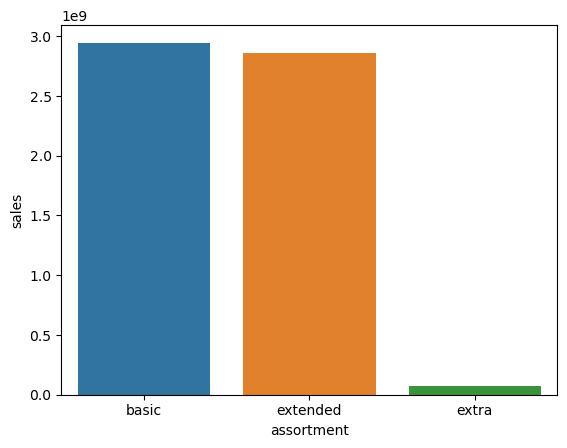

In [143]:
df_aux = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x=df_aux['assortment'], y=df_aux['sales'])

<AxesSubplot:xlabel='year_week'>

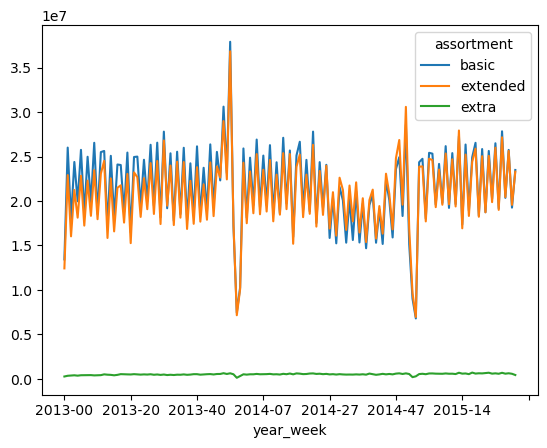

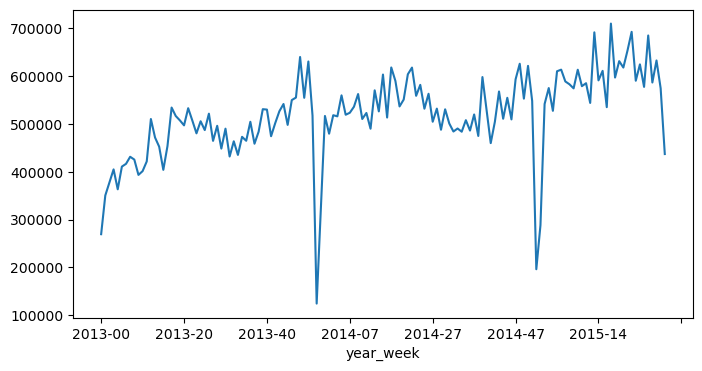

In [167]:
df_aux = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
df_aux = df_aux.pivot(index='year_week', columns='assortment', values='sales')
#plt.figure(figsize=(16,6))
#plt.subplot(2,1,1)
df_aux.plot()
#plt.subplot(2,1,2)
plt.figure(figsize=(8,4))
df_aux['extra'].plot()

### H2 - Lojas com competidores mais próximos deveriam vender menos  
Falso, conforme abaixo, lojas com competidores mais próximos vendem mais

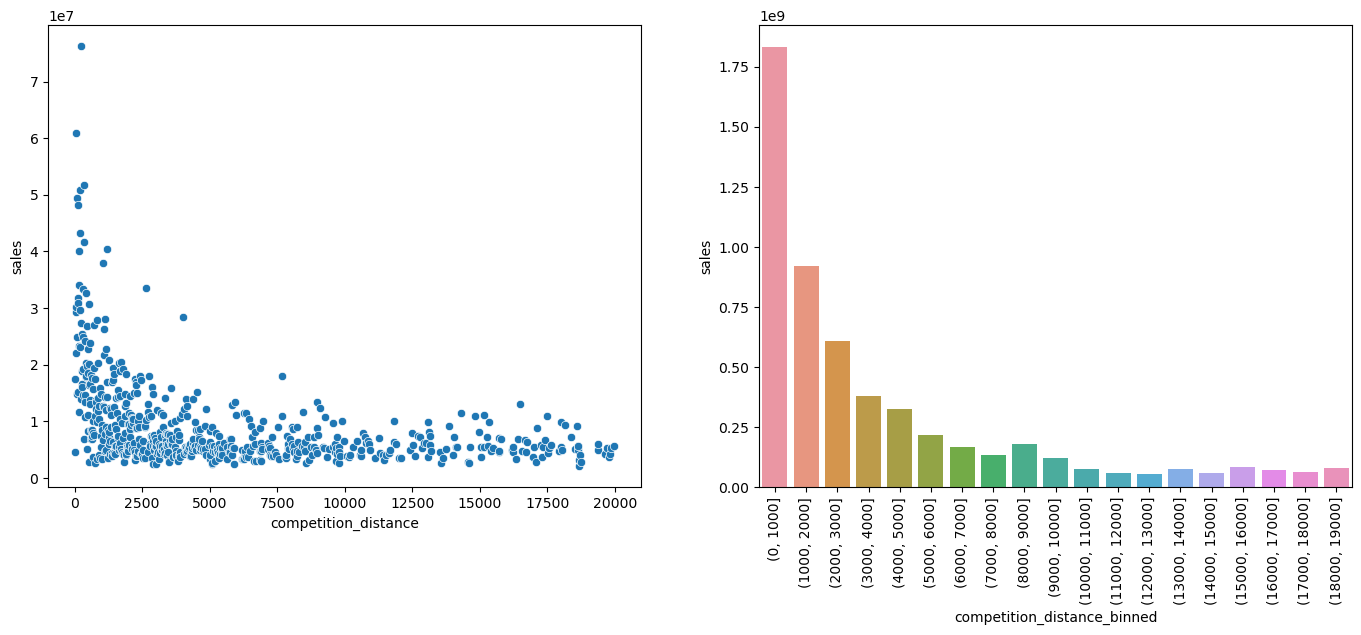

In [181]:
plt.figure(figsize=(26,6))
plt.subplot(1, 3, 1)
df_aux = df4[df4['competition_distance'] < 20000]
df_aux = df_aux[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x=df_aux['competition_distance'], y=df_aux['sales'])
df_aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0, 20000, 1000))
df_aux['competition_distance_binned'] = pd.cut(df_aux['competition_distance'], bins=bins)
df_aux = df_aux[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(1, 3, 2)
sns.barplot(x=df_aux['competition_distance_binned'], y=df_aux['sales'])
plt.xticks(rotation=90);

### H3 - Lojas com competidores a mais tempo deveriam vender mais  
False. Lojas com COMPETIDORES a mais tempo vendem MENOS


In [191]:
df_aux['competition_time_month'].quantile(0.75)

250.5

<AxesSubplot:>

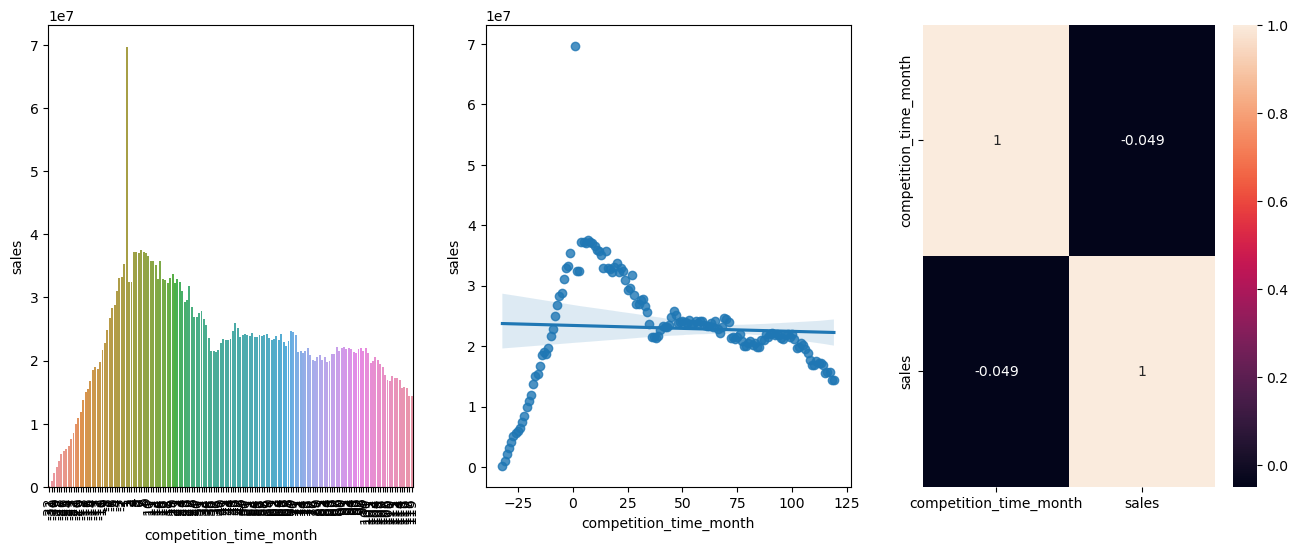

In [198]:
df_aux = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
df_aux = df_aux[(df_aux['competition_time_month'] != 0) & (df_aux['competition_time_month'] < 120)]
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
sns.barplot(x=df_aux['competition_time_month'], y=df_aux['sales'])
plt.xticks(rotation=90);
plt.subplot(1, 3, 2)
sns.regplot(x=df_aux['competition_time_month'], y=df_aux['sales'])
plt.subplot(1, 3, 3)
sns.heatmap(df_aux.corr(method='pearson'), annot=True)

In [183]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'in_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### H4 - Lojas com promoções ativas por mais tempo deveriam vender mais  

In [ ]:



5 - Lojas com mais dias de promoção deveriam vender mais  
6 - Lojas com mais promoções consecutivas deveriam vender mais  
7 - Lojas abertas durante o feriado de natal deveriam vender mais  
8 - Lojas deveriam vender mais ao longo dos anos  
9 - Lojas deveriam vender mais no segundo semestre do ano  
10 - Lojas deveriam vender mais depois do dia 10 de cada mês  
11 - Lojas deveriam vender menos aos finais de semana  
12 - Lojas deveriam vender menos durante os feriados escolares  

## Multivariate Analysis